In [150]:
from pathlib import Path
import os
import time

import requests
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
from pvlib.pvsystem import PVSystem, Array, SingleAxisTrackerMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain as PVModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import PySAM.ResourceTools as tools
from windpowerlib import ModelChain as WindModelChain
from windpowerlib import WindTurbine


# Solar

### Load weather

In [133]:
API_KEY = os.environ.get('NREL_API_KEY')
EMAIL = "adufour@stanford.edu"
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-5min-download.json?"
POINTS = ['640221']
lat_pv, lon_pv = 37.3663, -121.1253
year = 2022
interval = 15

In [134]:
def get_response_json_and_handle_errors(response: requests.Response) -> dict:
    """Takes the given response and handles any errors, along with providing
    the resulting json

    Parameters
    ----------
    response : requests.Response
        The response object

    Returns
    -------
    dict
        The resulting json
    """
    if response.status_code != 200:
        print(f"An error has occurred with the server or the request. The request response code/status: {response.status_code} {response.reason}")
        print(f"The response body: {response.text}")
        exit(1)

    try:
        response_json = response.json()
    except:
        print(f"The response couldn't be parsed as JSON, likely an issue with the server, here is the text: {response.text}")
        exit(1)

    if len(response_json['errors']) > 0:
        errors = '\n'.join(response_json['errors'])
        print(f"The request errored out, here are the errors: {errors}")
        exit(1)
    return response_json

In [105]:
input_data = {
    'attributes': 'dhi,dni,wind_speed,air_temperature,ghi,solar_zenith_angle,total_precipitable_water',
    'interval': str(interval),
    'to_utc': 'false',
    'include_leap_day': 'true',
    
    'api_key': API_KEY,
    'email': EMAIL,
}

for name in [str(year)]:
    print(f"Processing name: {name}")
    for id, location_ids in enumerate(POINTS):
        input_data['names'] = [name]
        input_data['location_ids'] = location_ids
        print(f'Making request for point group {id + 1} of {len(POINTS)}...')

        if '.csv' in BASE_URL:
            url = BASE_URL + urllib.parse.urlencode(data, True)
            # Note: CSV format is only supported for single point requests
            # Suggest that you might append to a larger data frame
            data = pd.read_csv(url)
            print(f'Response data (you should replace this print statement with your processing): {data}')
            # You can use the following code to write it to a file
            # data.to_csv('SingleBigDataPoint.csv')
        else:
            headers = {
                'x-api-key': API_KEY
            }
            data = get_response_json_and_handle_errors(requests.post(BASE_URL, input_data, headers=headers))
            download_url = data['outputs']['downloadUrl']
            # You can do with what you will the download url
            print(data['outputs']['message'])
            print(f"Data can be downloaded from this url when ready: {download_url}")

            # Delay for 1 second to prevent rate limiting
            time.sleep(1)
        print(f'Processed')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): developer.nrel.gov:443


Processing name: 2022
Making request for point group 1 of 1...


DEBUG:urllib3.connectionpool:https://developer.nrel.gov:443 "POST /api/nsrdb/v2/solar/psm3-5min-download.json HTTP/1.1" 200 None


File generation in progress. An email will be sent to adufour@stanford.edu when the download is ready.
Data can be downloaded from this url when ready: https://mapfiles.nrel.gov/data/solar/07f45ccee64d99750640db46f4eaa482.zip
Processed


### Build system

In [135]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
cec_module = cec_modules['Canadian_Solar_Inc__CS6X_330P']
cec_inverter = cec_inverters['Canadian_Solar_Inc___CSI_3000TL_CT__240V_']
mps = 10

In [136]:
print("min series", cec_inverter.Mppt_low / (cec_module.V_mp_ref + 45*cec_module.beta_oc))

min series 3.2364250578268243


In [137]:
print("max series", cec_inverter.Mppt_high / (cec_module.V_mp_ref - 10 *cec_module.beta_oc))

max series 12.176045935299083


In [138]:
mount = SingleAxisTrackerMount()
array = Array(mount,
              module_parameters=cec_module,
              modules_per_string=mps,
              temperature_model_parameters=temperature_model_parameters)
system = PVSystem(array,
                  inverter_parameters=cec_inverter)

In [139]:
location = Location(latitude=lat_pv, longitude=lon_pv)

In [140]:
mc_pv = PVModelChain(system, location, aoi_model='physical')

### Process weather

In [148]:
pv_weather_path = Path('.') / "layouts" / "weather_files" / "utility_scale_solar.csv"
weather_pv, metadata_pv = pvlib.iotools.read_psm3(pv_weather_path, map_variables=True)

In [142]:
mc_pv.run_model(weather_pv)

/opt/miniconda3/envs/efes/lib/python3.11/site-packages/pvlib/spectrum/mismatch.py:359: UserWarning: Exceptionally low pw values replaced with 0.1 cm to prevent model divergence
  warn('Exceptionally low pw values replaced with '


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x172a7ac50>


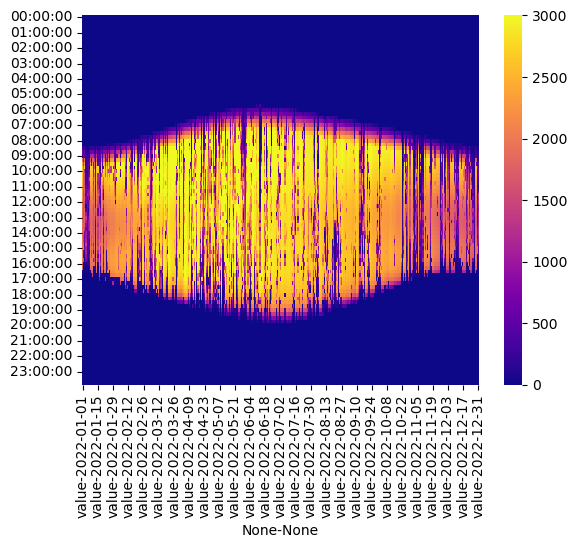

In [143]:
res =  mc_pv.results.ac
df = pd.DataFrame({'value': res})
pivot = pd.pivot_table(df, index=df.index.time, columns=df.index.date)
sns.heatmap(pivot, cmap='plasma');

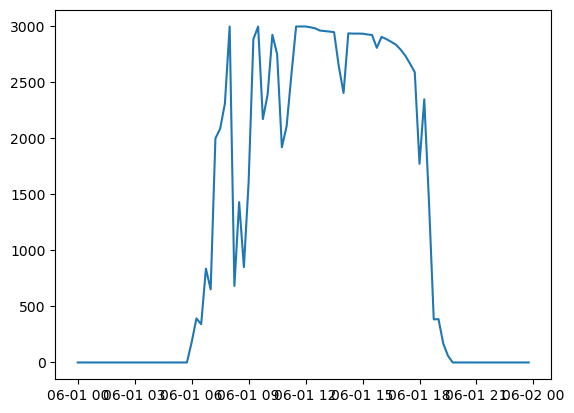

In [145]:
plt.plot(mc_pv.results.ac['2022-06-01']);

In [146]:
lf = mc_pv.results.ac.sum() / (mps*cec_module.STC*8760*4)
print(f"load factor: {np.round(100*lf,1)} %")

load factor: 26.5 %


In [149]:
pv_load = mc_pv.results.ac / (mps*cec_module.STC) # MW per MWdc
pv_load = pv_load.clip(0)
pv_save_path = Path('.') / "layouts" / "renewable_loadprofiles" / "utility_scale_solar.csv"
pv_load.to_csv(pv_save_path)

# Wind

### Load weather

In [159]:
sam_api_key = os.environ.get('NREL_API_KEY')
sam_email = "adufour@stanford.edu"
wind_weather_path = Path('.') / "layouts" / "weather_files" / "wind"
wtkfetcher = tools.FetchResourceFiles(
                tech='wind',
                resource_dir=wind_weather_path,
                nrel_api_key=sam_api_key,
                nrel_api_email=sam_email,
                resource_interval_min=15,
                resource_height=140)
# Altamont wind farm
lon_wind = -121.6525
lat_wind = 37.7325

In [160]:
lon_lats = [(lon_wind, lat_wind)]
wtkfetcher.fetch(lon_lats);

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): developer.nrel.gov:443



Starting data download for wind using 1 thread workers.


DEBUG:urllib3.connectionpool:https://developer.nrel.gov:443 "GET /api/wind-toolkit/v2/wind/wtk-download.csv?api_key=beADLR9fUg03YSeTX54heDgWMNf7xYqLN8tfSPhO&wkt=POINT(-121.6525+37.7325)&attributes=windspeed_140m,winddirection_140m,temperature_140m,pressure_100m&names=2014&utc=false&interval=15&email=adufour@stanford.edu HTTP/1.1" 302 120
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mapfiles.nrel.gov:443
DEBUG:urllib3.connectionpool:https://mapfiles.nrel.gov:443 "GET /data/wind/184029_37.73_-121.65_2014_5d957fb3601a009e2c9db5a53027f82b.csv HTTP/1.1" 301 169
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): gds-hsds-wtk-files.nrelcloud.org:443
DEBUG:urllib3.connectionpool:https://gds-hsds-wtk-files.nrelcloud.org:443 "GET /data/wind/184029_37.73_-121.65_2014_5d957fb3601a009e2c9db5a53027f82b.csv HTTP/1.1" 200 1554665


Success! File downloaded to layouts/weather_files/wind/windtoolkit_37.7325_-121.6525_15min_140m_2014.csv.


In [163]:
read_wind_weather_path = Path('.') / "layouts" / "weather_files" / "wind" / "windtoolkit_37.7325_-121.6525_15min_140m_2014.csv"
weather_wind = pd.read_csv(read_wind_weather_path, skiprows=1)
weather_wind['datetime'] = pd.to_datetime(weather_wind[['Year', 'Month', 'Day', 'Hour', 'Minute']])
weather_wind = weather_wind.set_index('datetime')
weather_wind = weather_wind.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])
mapping = {
    ('pressure', 100): weather_wind['air pressure at 100m (Pa)'],
    ('wind_speed', 140): weather_wind['wind speed at 140m (m/s)'],
    ('wind_direction', 140): weather_wind['wind direction at 140m (deg)'],
    ('temperature', 140): weather_wind['air temperature at 140m (C)']
}

# Convert to a DataFrame and set the MultiIndex columns
weather_wind = pd.DataFrame(mapping)
weather_wind.columns = pd.MultiIndex.from_tuples(weather_wind.columns, names=['variable_name', 'height'])

### Build system

In [164]:
ge_120 = {
        'turbine_type': 'GE120/2750',  # turbine type as in oedb turbine library
        'hub_height': 140  # in m
    }
# initialize WindTurbine object
ge120 = WindTurbine(**ge_120)

### Process weather

In [168]:
mc_wind = WindModelChain(ge120).run_model(weather_wind)

DEBUG:root:Calculating power output using power curve.


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x2ab96e8d0>


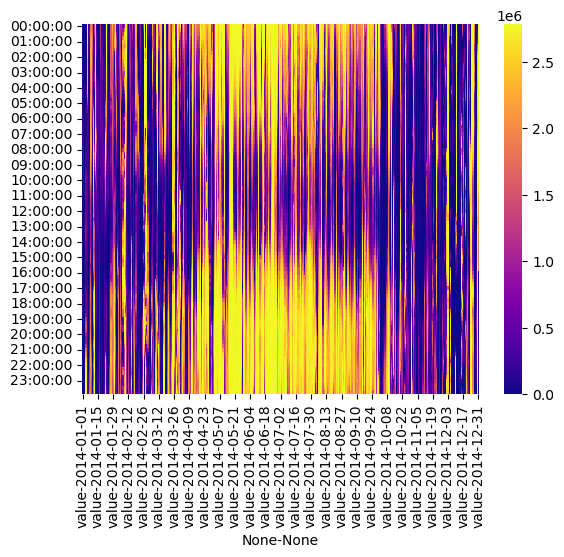

In [169]:
res =  mc_wind.power_output
df = pd.DataFrame({'value': res})
pivot = pd.pivot_table(df, index=df.index.time, columns=df.index.date)
sns.heatmap(pivot, cmap='plasma');

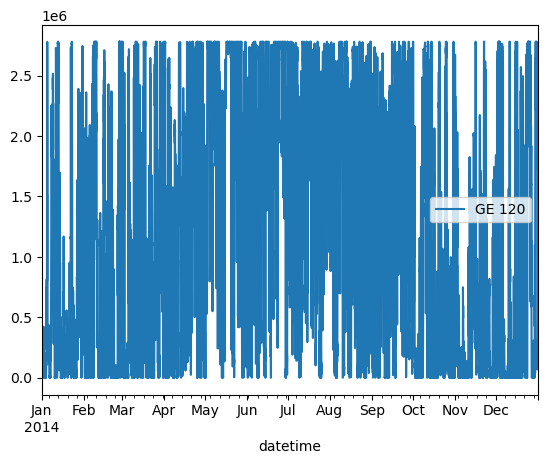

In [170]:
res.plot(legend=True, label='GE 120');

In [176]:
lf = mc_wind.power_output.sum() / (mc_wind.power_output.max()*8760*4)
print(f"load factor: {np.round(100*lf,1)} %")
lf2 = mc_wind.power_output.sum()*0.9 / (mc_wind.power_output.max()*8760*4) # to account for fleet
print(f"load factor: {np.round(100*lf2,1)} %")

load factor: 44.1 %
load factor: 39.7 %


In [177]:
wind_load = mc_wind.power_output*0.9 / (mc_wind.power_output.max())
wind_load = wind_load.clip(0)
wind_save_path = Path('.') / "layouts" / "renewable_loadprofiles" / "wind.csv"
wind_load.to_csv(wind_save_path)